In [1]:
from pyspark.sql import SparkSession
import os
import boto3
from botocore.client import Config
import cv2 as cv
import numpy as np
from pyspark.sql import functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import io
from keras.utils.data_utils import get_file
import tensorflow as tf

# 1. Create spark session

In [2]:
spark = SparkSession \
    .builder.master("k8s://https://kubernetes.default.svc:443") \
    .appName("SparkStreamingComputerVision") \
    .config("spark.kubernetes.container.image", "liupengfei99/sparkstreamincv:latest") \
    .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.memory","8g") \
    .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
    .getOrCreate()


In [3]:
# make the large dataframe show pretty
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
configurations = spark.sparkContext.getConf().getAll()
for item in configurations: print(item)

('spark.app.id', 'spark-application-1624894245079')
('spark.app.name', 'SparkStreamingComputerVision')
('spark.kubernetes.namespace', 'user-pengfei')
('spark.kubernetes.executor.podNamePrefix', 'sparkstreamingcomputervision-5810757a533e864b')
('spark.master', 'k8s://https://kubernetes.default.svc:443')
('spark.executor.id', 'driver')
('spark.kubernetes.authenticate.driver.serviceAccountName', 'jupyter-1624865272')
('spark.app.startTime', '1624894243483')
('spark.sql.warehouse.dir', 'file:/home/jovyan/work/SparkStreamingCV/notebook/spark-warehouse')
('spark.kubernetes.container.image', 'liupengfei99/sparkstreamincv:latest')
('spark.rdd.compress', 'True')
('spark.executor.instances', '2')
('spark.serializer.objectStreamReset', '100')
('spark.executor.memory', '8g')
('spark.submit.pyFiles', '')
('spark.submit.deployMode', 'client')
('spark.driver.host', 'jupyter.jupyter-1624865272.user-pengfei.svc.cluster.local')
('spark.ui.showConsoleProgress', 'true')
('spark.driver.port', '45167')


## 1.1 Check the created cluster

In [5]:
! kubectl get pods

NAME                                                   READY   STATUS      RESTARTS   AGE
deleting-pods-with-completed-status-1624892400-28sk6   0/1     Completed   0          30m
jupyter-1624865272-745f99d567-2xfr5                    1/1     Running     0          8h
mlflow-1623856609-7cb57fbd9f-jjtsk                     1/1     Running     0          12d
mlflow-db-0                                            1/1     Running     0          12d
mlflow-deployment-dd54d6c6b-xnglp                      1/1     Running     0          69d
mlflow-model-deployment-869dd96bbf-2dfwl               1/1     Running     0          11d
postgres-1616502799-67f86f5bdf-wfgjx                   1/1     Running     0          97d
sparkstreamingcomputervision-5810757a533e864b-exec-1   1/1     Running     0          16s
sparkstreamingcomputervision-5810757a533e864b-exec-2   1/1     Running     0          16s
ubuntu-1616490233-56d6684bb4-trwqt                     1/1     Running     2          97d


# 2. Set up variables and dependent functions

# 2.1 Variables

In [6]:
bucket_name="pengfei"
image_input_folder_path = "s3a://{}/tmp/sparkcv/input".format(bucket_name)
final_output_bucket_path = "tmp/sparkcv/output/final"
face_mask_model_url="https://minio.lab.sspcloud.fr/projet-spark-lab/diffusion/spark_cv/models/masknet.h5"

In [7]:
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
AWS_ACCESS_KEY_ID=os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY=os.getenv("AWS_SECRET_ACCESS_KEY")
SESSION_TOKEN=os.environ['AWS_SESSION_TOKEN']

## 2.2 helper functions

In [8]:
# deseriallize byte to opencv image format
def convert_byte_to_nparr(img_byte):
    np_array = cv.imdecode(np.asarray(bytearray(img_byte)), cv.IMREAD_COLOR)
    return np_array

# serialize opencv image format to byte
def convert_nparr_to_byte(img_np_array):
    success, img = cv.imencode('.png', img_np_array)
    return img.tobytes()

# save image byte to s3
def write_img_byte_to_s3(s3_client, img_byte, bucket_name, img_path):
    # set the path of where you want to put the object
    img_object = s3_client.Object(bucket_name, img_path)
    # set the content which you want to write
    img_object.put(Body=img_byte)

# column function for extract image name
def extract_file_name(path):
    return f.substring_index(path, "/", -1)

# render image byte in jupyter
def render_image(image_bytes_list):
    for image_bytes in image_bytes_list:
        image=Image.open(io.BytesIO(image_bytes))
        display(image)

### Helper functions for step 2 (Extract multiple faces from the origin image) 

In [9]:
def face_extraction(image_name, raw_img_content):
    haar_model_name = "haarcascade_frontalface_default.xml"
    haar_model_path = "{}{}".format("/opt/conda/lib/python3.7/site-packages/cv2/data/",haar_model_name)
    img = cv.imdecode(np.asarray(bytearray(raw_img_content)), cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.IMREAD_GRAYSCALE)
    face_model = cv.CascadeClassifier(haar_model_path)
    faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)  # returns a list of (x,y,w,h) tuples

    # Extract faces from the origin image
    extracted_face_list = []
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        img_content = img[y:y + h, x:x + w]
        img_content = cv.resize(img_content, (128, 128))
        extracted_face_img_name = image_name[:-4] + "_x" + str(x) + "_y" + str(y) + "_w" + str(
            w) + "_h" + str(h) + ".png"
        img_byte = convert_nparr_to_byte(img_content)

        extracted_face_list.append((extracted_face_img_name, img_byte))
    return extracted_face_list


face_extraction_schema = ArrayType(StructType([
    StructField("img_name", StringType(), False),
    StructField("img_content", BinaryType(), False)
]))

Face_Extraction_UDF = f.udf(lambda image_name, raw_image_content: face_extraction(image_name, raw_image_content),
                            face_extraction_schema)


### Helper functions for step 3 (Predict if the extracted face wear a mask or not) 

In [11]:
def face_mask_prediction(np_img_str):
    vgg19_model_path = "/home/jovyan/work"
    vgg19_model_name = "masknet.h5"
    # read raw face image
    np_arr_img = convert_byte_to_nparr(np_img_str)
    img = np.reshape(np_arr_img, [1, 128, 128, 3])
    img = img / 255.0
    # fetch model from s3 
    model_path = get_file('masknet.h5', face_mask_model_url)
    vgg19_model = tf.keras.models.load_model(model_path)
    
    score = vgg19_model.predict(img)
    if np.argmax(score) == 0:
        res = True
    else:
        res = False
    # print(res)
    return res


Face_Mask_Prediction_UDF = f.udf(lambda face_image_content: face_mask_prediction(face_image_content), BooleanType())

### Helper functions for step 4(Integrate the prediction result to the original image)

In [12]:
# 
def get_face_coordinate_of_origin_image(face_image_name):
    x = face_image_name.split("_")[1][1:]
    y = face_image_name.split("_")[2][1:]
    w = face_image_name.split("_")[3][1:]
    h = face_image_name.split("_")[4][1:].split('.')[0]
    return int(x), int(y), int(w), int(h)


def integrate_face_mask_prediction(origin_image_name, face_list, origin_image_content):
    final_output_path = "/tmp/sparkcv/output/final/{}".format(origin_image_name)
    buffer_img = cv.imdecode(np.asarray(bytearray(origin_image_content)), cv.IMREAD_COLOR)
    for face in face_list:
        face_image_name = face[0]
        has_mask = face[1]
        # set Label text
        if has_mask:
            mask_label = "MASK"
        else:
            mask_label = "NO MASK"
        # Get the coordinate and size of face image
        (x, y, w, h) = get_face_coordinate_of_origin_image(face_image_name)
        # Set text color for mask label
        mask_label_color = {"MASK": (0, 255, 0), "NO MASK": (0, 0, 255)}

        # Insert mask label to image
        buffer_img = cv.putText(buffer_img, mask_label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5,
                                mask_label_color[mask_label], 2)
        # Insert a rectangle around the face
        buffer_img = cv.rectangle(buffer_img, (x, y), (x + w, y + h), mask_label_color[mask_label], 1)
    # serialize cv image to bytes
    img_bytes=convert_nparr_to_byte(buffer_img)
    # Save the image to s3
    s3_client = boto3.resource('s3',endpoint_url=endpoint,aws_access_key_id=AWS_ACCESS_KEY_ID,
                               aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                               aws_session_token=SESSION_TOKEN,
                               config=Config(signature_version='s3v4'),
                               region_name='us-east-1')
    output_bucket_key="{}/{}".format(final_output_bucket_path,origin_image_name)
    write_img_byte_to_s3(s3_client, img_bytes, bucket_name, output_bucket_key)
    return img_bytes


Integrate_Face_Mask_Prediction_UDF = f.udf(
    lambda origin_img_name, face_list, origin_img_content: integrate_face_mask_prediction(origin_img_name, face_list,origin_img_content),BinaryType())

# Main data pipeline for treating image
To check if everyone wears a face mask or not in an image, we will follow the below steps:
1. Read raw image from s3
2. Detect faces from the raw image, output extracted faces as single images(opencv:haar-cascade)
3. Use a pre-trained vgg19 model to check if a mask is worn
4. Integrate prediction as tags on origin image

## Step 1: Get raw image from s3

In [13]:
image_schema = spark.read.format("binaryFile").load(image_input_folder_path).schema
raw_image_df = spark.read \
        .format("binaryFile") \
        .schema(image_schema) \
        .option("maxFilesPerTrigger", "500") \
        .option("recursiveFileLookup", "true") \
        .option("pathGlobFilter", "*.png") \
        .load(image_input_folder_path)
raw_image_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://pengfei/tmp...|2021-06-16 11:50:15|603249|[89 50 4E 47 0D 0...|
|s3a://pengfei/tmp...|2021-06-16 11:50:14|225594|[89 50 4E 47 0D 0...|
|s3a://pengfei/tmp...|2021-06-16 11:50:14|194146|[89 50 4E 47 0D 0...|
+--------------------+-------------------+------+--------------------+



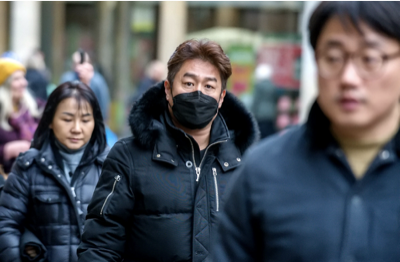

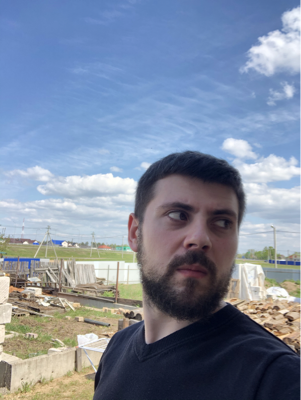

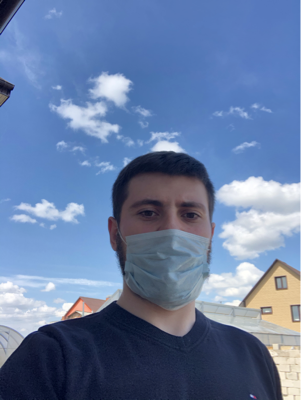

In [14]:
# show the origin image
origin_col_name="content"
origin_image_list = raw_image_df.select(origin_col_name).toPandas()[origin_col_name]
render_image(origin_image_list)

### 1.1 Clean the data frame

In [15]:
image_name_df = raw_image_df \
        .select("path", "content") \
        .withColumn("origin_image_name", extract_file_name(f.col("path"))).drop("path")
image_name_df.show()

+--------------------+-------------------+
|             content|  origin_image_name|
+--------------------+-------------------+
|[89 50 4E 47 0D 0...|maksssksksss244.png|
|[89 50 4E 47 0D 0...| maksssksksss14.png|
|[89 50 4E 47 0D 0...|maksssksksss107.png|
+--------------------+-------------------+



## Step 2: Extract faces

In [16]:
# use udf Face_Extraction_UDF to extract faces
detected_face_list_df = image_name_df.withColumn("detected_face_list",Face_Extraction_UDF("origin_image_name", "content"))
detected_face_list_df.show()
detected_face_list_df.printSchema()

+--------------------+-------------------+--------------------+
|             content|  origin_image_name|  detected_face_list|
+--------------------+-------------------+--------------------+
|[89 50 4E 47 0D 0...|maksssksksss244.png|[{maksssksksss244...|
|[89 50 4E 47 0D 0...| maksssksksss14.png|[{maksssksksss14_...|
|[89 50 4E 47 0D 0...|maksssksksss107.png|[{maksssksksss107...|
+--------------------+-------------------+--------------------+

root
 |-- content: binary (nullable = true)
 |-- origin_image_name: string (nullable = true)
 |-- detected_face_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- img_name: string (nullable = false)
 |    |    |-- img_content: binary (nullable = false)



In [17]:
# Flat the list column to multi rows
detected_face_ob_df = detected_face_list_df.withColumn("extracted_face",f.explode(f.col("detected_face_list"))).drop("detected_face_list")
detected_face_ob_df.show()
detected_face_ob_df.printSchema()

+--------------------+-------------------+--------------------+
|             content|  origin_image_name|      extracted_face|
+--------------------+-------------------+--------------------+
|[89 50 4E 47 0D 0...|maksssksksss244.png|{maksssksksss244_...|
|[89 50 4E 47 0D 0...|maksssksksss244.png|{maksssksksss244_...|
|[89 50 4E 47 0D 0...|maksssksksss244.png|{maksssksksss244_...|
|[89 50 4E 47 0D 0...| maksssksksss14.png|{maksssksksss14_x...|
|[89 50 4E 47 0D 0...|maksssksksss107.png|{maksssksksss107_...|
+--------------------+-------------------+--------------------+

root
 |-- content: binary (nullable = true)
 |-- origin_image_name: string (nullable = true)
 |-- extracted_face: struct (nullable = true)
 |    |-- img_name: string (nullable = false)
 |    |-- img_content: binary (nullable = false)



In [18]:
# flat the struct column to primitive column
detected_face_df = detected_face_ob_df.select(f.col("origin_image_name"),f.col("content"),
                                                  f.col("extracted_face.img_name").alias("extracted_face_image_name"),
                                                  f.col("extracted_face.img_content").alias(
                                                      "extracted_face_image_content"))
detected_face_df.show()
detected_face_df.printSchema()

+-------------------+--------------------+-------------------------+----------------------------+
|  origin_image_name|             content|extracted_face_image_name|extracted_face_image_content|
+-------------------+--------------------+-------------------------+----------------------------+
|maksssksksss244.png|[89 50 4E 47 0D 0...|     maksssksksss244_x...|        [89 50 4E 47 0D 0...|
|maksssksksss244.png|[89 50 4E 47 0D 0...|     maksssksksss244_x...|        [89 50 4E 47 0D 0...|
|maksssksksss244.png|[89 50 4E 47 0D 0...|     maksssksksss244_x...|        [89 50 4E 47 0D 0...|
| maksssksksss14.png|[89 50 4E 47 0D 0...|     maksssksksss14_x1...|        [89 50 4E 47 0D 0...|
|maksssksksss107.png|[89 50 4E 47 0D 0...|     maksssksksss107_x...|        [89 50 4E 47 0D 0...|
+-------------------+--------------------+-------------------------+----------------------------+

root
 |-- origin_image_name: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- extracted_face_imag

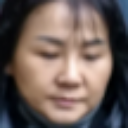

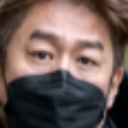

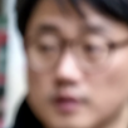

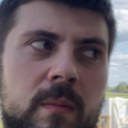

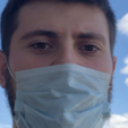

In [19]:
# show the extracted faces
face_col_name="extracted_face_image_content"
face_image_list = detected_face_df.select(face_col_name).toPandas()[face_col_name]
render_image(face_image_list)

## Step3 : Predict if the extracted faces wear masks or not

In [20]:
predicted_mask_df = detected_face_df.withColumn("with_mask",Face_Mask_Prediction_UDF("extracted_face_image_content")).cache()
predicted_mask_df.show()
predicted_mask_df.printSchema()


+-------------------+--------------------+-------------------------+----------------------------+---------+
|  origin_image_name|             content|extracted_face_image_name|extracted_face_image_content|with_mask|
+-------------------+--------------------+-------------------------+----------------------------+---------+
|maksssksksss244.png|[89 50 4E 47 0D 0...|     maksssksksss244_x...|        [89 50 4E 47 0D 0...|    false|
|maksssksksss244.png|[89 50 4E 47 0D 0...|     maksssksksss244_x...|        [89 50 4E 47 0D 0...|     true|
|maksssksksss244.png|[89 50 4E 47 0D 0...|     maksssksksss244_x...|        [89 50 4E 47 0D 0...|    false|
| maksssksksss14.png|[89 50 4E 47 0D 0...|     maksssksksss14_x1...|        [89 50 4E 47 0D 0...|    false|
|maksssksksss107.png|[89 50 4E 47 0D 0...|     maksssksksss107_x...|        [89 50 4E 47 0D 0...|     true|
+-------------------+--------------------+-------------------------+----------------------------+---------+

root
 |-- origin_image_name

## Step 4: Integrate the prediction result to the original image

In [21]:
# map the face name with the mask prediction result and group them by their origin 
grouped_face_df = predicted_mask_df.drop("extracted_face_image_content").groupBy("origin_image_name","content").agg(f.collect_list(f.struct(
                *[f.col("extracted_face_image_name").alias("face_name"), f.col("with_mask").alias("with_mask")]))
            .alias("face_list"))

grouped_face_df.show()

+-------------------+--------------------+--------------------+
|  origin_image_name|             content|           face_list|
+-------------------+--------------------+--------------------+
| maksssksksss14.png|[89 50 4E 47 0D 0...|[{maksssksksss14_...|
|maksssksksss244.png|[89 50 4E 47 0D 0...|[{maksssksksss244...|
|maksssksksss107.png|[89 50 4E 47 0D 0...|[{maksssksksss107...|
+-------------------+--------------------+--------------------+



In [ ]:
# integrate prediction and write to s3
final_df = grouped_face_df.withColumn("marked_img_content",Integrate_Face_Mask_Prediction_UDF("origin_image_name", "face_list","content"))
final_df.show()

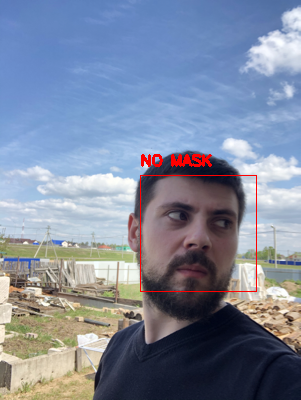

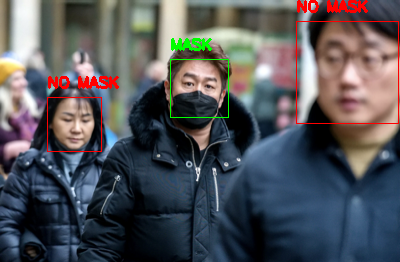

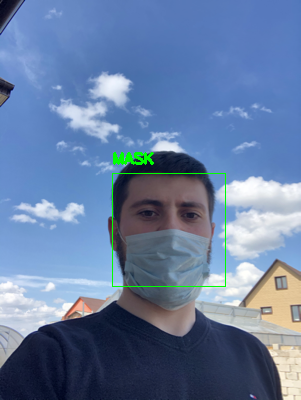

In [22]:
# show the marked_img_content
col_name="marked_img_content"
image_list = final_df.select(col_name).toPandas()[col_name]
render_image(image_list)

In [23]:
# stop sparksession
spark.sparkContext.stop()

In [ ]:
# notebook dependencies
pip install opencv-contrib-python
pip install mlflow --user
git clone https://github.com/pengfei99/SparkStreamingCV.git
pip install tensorflow
pip install --upgrade  protobuf